# Phân tích cụm hỗn hợp

**Lê Ngọc Khả Nhi**

## Giới thiệu 

Cluster analysis là một phương pháp phân tích dữ liệu thuộc nhóm Unsupervised learning, và được dùng khá phổ biến trong nghiên cứu y học trên dữ liệu đa biến. Clustering có những ứng dụng lý thú, thậm chí một số trường hợp nó cho phép phát hiện ra những kiến thức mới từ dữ liệu.

Tuy nhiên như chúng ta biết, các phân tích Cluster thường chỉ chấp nhận dữ liệu định lượng (matrix gồm toàn những con số). 

Trong bài thực hành hôm nay, Nhi sẽ giới thiệu với các bạn một công cụ mới trong R cho phép làm phân tích cụm cho dữ liệu hỗn hợp gồm cả biến định lượng và định tính.

## Chuẩn bị dữ liệu

In [1]:
library(tidyverse)

my_theme <- function(base_size = 10, base_family = "sans"){
  theme_minimal(base_size = base_size, base_family = base_family) +
    theme(
      axis.text = element_text(size = 10),
      axis.text.x = element_text(angle = 0, vjust = 0.5, hjust = 0.5),
      axis.title = element_text(size = 10),
      panel.grid.major = element_line(color = "gray"),
      panel.grid.minor = element_blank(),
      panel.background = element_rect(fill = "#f7fdff"),
      strip.background = element_rect(fill = "#001d60", color = "#00113a", size =0.5),
      strip.text = element_text(face = "bold", size = 10, color = "white"),
      legend.position = "bottom",
      legend.justification = "center",
      legend.background = element_blank(),
      panel.border = element_rect(color = "grey5", fill = NA, size = 0.5)
    )
}

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.1.1       v purrr   0.3.2  
v tibble  2.1.1       v dplyr   0.8.0.1
v tidyr   0.8.3       v stringr 1.4.0  
v readr   1.3.1       v forcats 0.4.0  
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


In [3]:
theme_set(my_theme())
clust_colmap = c("#f7286d","#1faae0","#ffbf1f")

Nhi sử dụng một dữ liệu có thực, đó là dataset Chronic_Kidney_Disease mà các bạn có thể tải từ UCI database
https://archive.ics.uci.edu/ml/datasets/Chronic_Kidney_Disease

Dữ liệu này chứa cả biến định tính và định lượng, và nội dung có thể chia thành 2 nhóm: Thông tin lâm sàng (gồm hơn 20 kết quả xét nghiệm, các chỉ số sinh lý, sinh hóa, tế bào học) và Chẩn đoán bệnh lý (gồm 3 bệnh: Cao huyết áp, Bệnh thận mạn tính và Tiểu đường). 

In [4]:
ckd=read.csv("chronic_kidney_disease.arff",
             header=F,
             comment.char="@",
             na.strings=c("?","","\t?"),)


names(ckd)=c("Age","BP","SPG","Albumin",
             "Sugar","RBC","PC",
             "PCC","Bact","BGlu",
             "BUrea","SerCreat",
             "Sodium","K","Hb",
             "PCV","WBC","RBCCount",
             "HTA","DIA","CAD",
             "APP","PedEdema",
             "Anemia","CKD")

ckd$DIA=recode_factor(ckd$DIA,
                      `yes`="TRUE",
                      `no`="FALSE",
                      `\tno`="FALSE",
                      `\tyes`="TRUE",
                      ` yes`="TRUE")%>%as.logical()

ckd$CKD=recode_factor(ckd$CKD,
                      `ckd`="TRUE",
                      `no`="FALSE",
                      `ckd\t`="TRUE",
                      `notckd`="FALSE")%>%as.logical()

ckd$HTA=recode_factor(ckd$HTA,
                      `yes`="TRUE",
                      `no`="FALSE")%>%as.logical()

ckd$Age=recode_factor(ckd$Age,
                      `notckd`="NA")%>%as.numeric()

df=select(ckd,c(Age,BP,RBCCount,SPG,Albumin,Sugar,PC,PCC,Bact,BGlu,BUrea,
                SerCreat,Sodium,K,Hb,PCV,WBC,Anemia,PedEdema,DIA,
                HTA,CKD))


df=subset(df,DIA!="NA" & HTA!="NA" & CKD!="NA")%>%as_tibble()

df$BP=as.numeric(df$BP)
df$BGlu=as.numeric(df$BGlu)
df$PCV=as.numeric(df$PCV)
df$WBC=as.numeric(df$WBC)
df$Albumin = as.factor(df$Albumin)
df$Sugar= as.factor(df$Sugar)

rm(ckd)

In [5]:
head(df)

Age,BP,RBCCount,SPG,Albumin,Sugar,PC,PCC,Bact,BGlu,...,Sodium,K,Hb,PCV,WBC,Anemia,PedEdema,DIA,HTA,CKD
38,80,5.2,1.020,1,0,normal,notpresent,notpresent,121,...,NA,NA,15.4,44,7800,no,no,TRUE,TRUE,TRUE
62,50,NA,1.020,4,0,normal,notpresent,notpresent,NA,...,NA,NA,11.3,38,6000,no,no,FALSE,FALSE,TRUE
54,80,NA,1.010,2,3,normal,notpresent,notpresent,423,...,NA,NA,9.6,31,7500,yes,no,TRUE,FALSE,TRUE
38,70,3.9,1.005,4,0,abnormal,present,notpresent,117,...,111,2.5,11.2,32,6700,yes,yes,FALSE,TRUE,TRUE
42,80,4.6,1.010,2,0,normal,notpresent,notpresent,106,...,NA,NA,11.6,35,7300,no,no,FALSE,FALSE,TRUE
52,90,4.4,1.015,3,0,NA,notpresent,notpresent,74,...,142,3.2,12.2,39,7800,no,yes,TRUE,TRUE,TRUE


Trước hết, chúng ta sẽ loại bỏ những biến có quá nhiều missing value ra khỏi dataset, sau đó áp dụng hàm na.omit() để dọn sạch những trường hợp missing value rải rác. Kết quả sau cùng là một dataframe có 288 bệnh nhân, 12 biến thông tin lâm sàng và 3 biến chẩn đoán.

In [12]:
bar_missing <- function(x){
  require(reshape2)
  x %>%
    is.na %>%
    melt %>%
    ggplot(data = .,
           aes(x = Var2)) +
    geom_bar(aes(y=(..count..),fill=value),alpha=0.7)+
    scale_fill_manual(values=c("skyblue","red"),
                      name = "",
                      labels = c("Available","Missing"))+
    theme_minimal()+
    theme(axis.text.x = element_text(angle=45, vjust=0.5)) +
    labs(x = "Variables in Dataset",
         y = "Observations")+coord_flip()
                          }

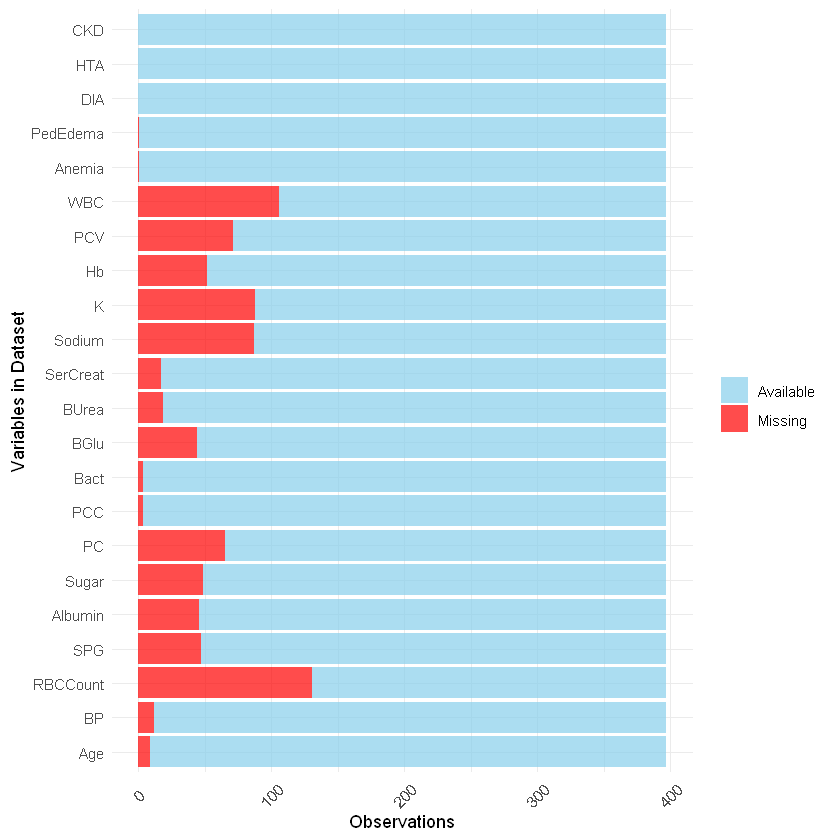

In [14]:
bar_missing(df)

In [15]:
df %>% select(CKD,HTA,DIA,
                    Age,BP,
                    Bact,PCC,Anemia,PedEdema,
                    SPG,Albumin,Sugar,BUrea,SerCreat,BGlu) %>%na.omit() -> df

str(df)

Classes 'tbl_df', 'tbl' and 'data.frame':	288 obs. of  15 variables:
 $ CKD     : logi  TRUE TRUE TRUE TRUE TRUE TRUE ...
 $ HTA     : logi  TRUE FALSE TRUE FALSE TRUE FALSE ...
 $ DIA     : logi  TRUE TRUE FALSE FALSE TRUE FALSE ...
 $ Age     : num  38 54 38 42 52 60 43 44 41 55 ...
 $ BP      : num  80 80 70 80 90 70 100 90 60 70 ...
 $ Bact    : Factor w/ 2 levels "notpresent","present": 1 1 1 1 1 1 1 1 1 1 ...
 $ PCC     : Factor w/ 2 levels "notpresent","present": 1 1 2 1 1 1 2 2 2 2 ...
 $ Anemia  : Factor w/ 2 levels "no","yes": 1 2 2 1 1 1 2 2 2 1 ...
 $ PedEdema: Factor w/ 3 levels "good","no","yes": 2 2 3 2 3 2 2 2 2 3 ...
 $ SPG     : num  1.02 1.01 1 1.01 1.01 ...
 $ Albumin : Factor w/ 6 levels "0","1","2","3",..: 2 3 5 3 4 1 4 3 3 4 ...
 $ Sugar   : Factor w/ 6 levels "0","1","2","3",..: 1 4 1 1 1 1 1 1 5 1 ...
 $ BUrea   : num  36 53 56 26 25 54 60 107 55 60 ...
 $ SerCreat: num  1.2 1.8 3.8 1.4 1.1 24 1.9 7.2 4 2.7 ...
 $ BGlu    : num  121 423 117 106 74 100 138 70 49

## Thăm dò và mô tả

Trong dữ liệu hiện thời, chúng ta có 6 biến định lượng và 6 biến định tính.

Phân bố của 6 biến định lượng ở từng bệnh lý được quan sát như sau:

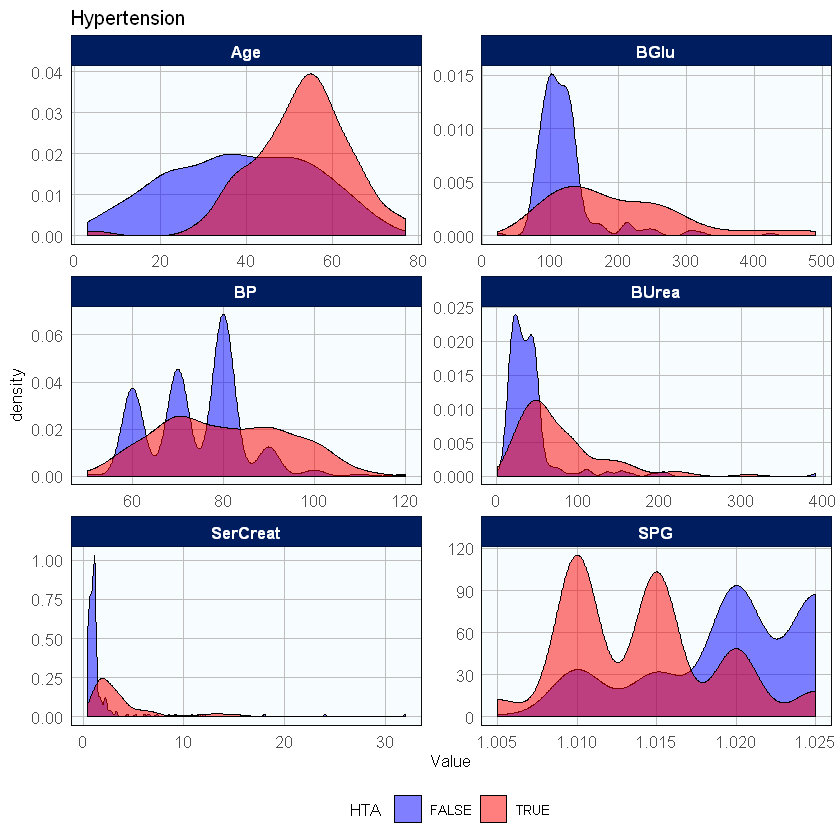

In [20]:
df %>% gather(c(Age,BP,SPG, BUrea:BGlu),
             key="Parameter",
             value="Value")%>%
  ggplot(aes(x=Value,fill=HTA))+
  geom_density(alpha=0.5)+
  ggtitle("Hypertension")+
  facet_wrap(~Parameter,ncol=2,scales="free")+
  scale_fill_manual(values = c("blue","red"))+
  my_theme()

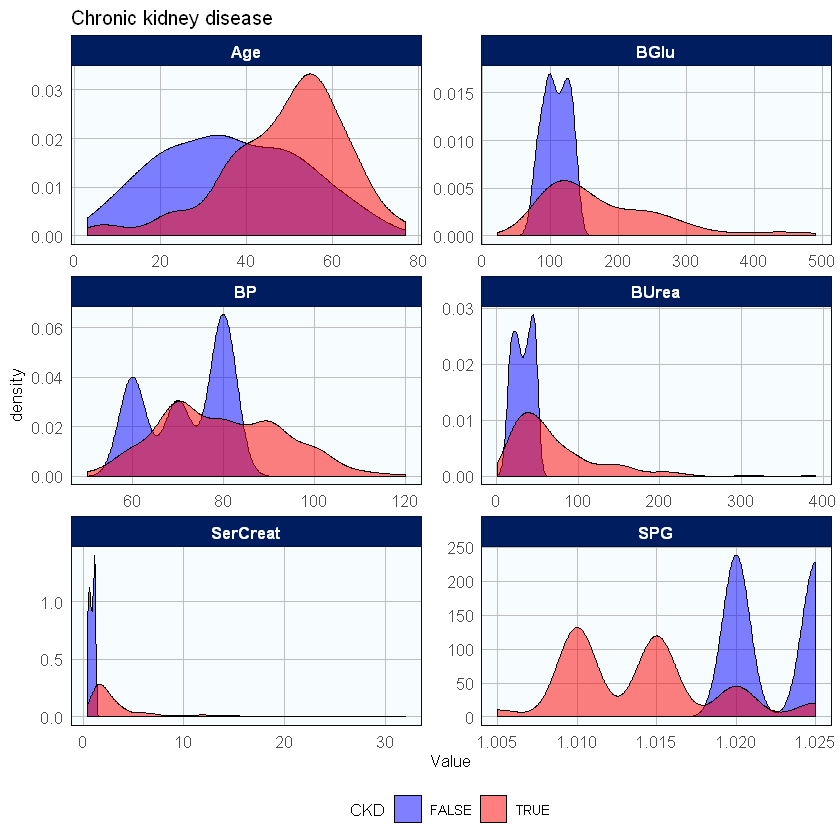

In [21]:
df %>% gather(c(Age,BP,SPG, BUrea:BGlu),
             key="Parameter",
             value="Value")%>%
  ggplot(aes(x=Value,fill=CKD))+
  geom_density(alpha=0.5)+
  ggtitle("Chronic kidney disease")+
  facet_wrap(~Parameter,ncol=2,scales="free")+
  scale_fill_manual(values = c("blue","red"))+
  my_theme()

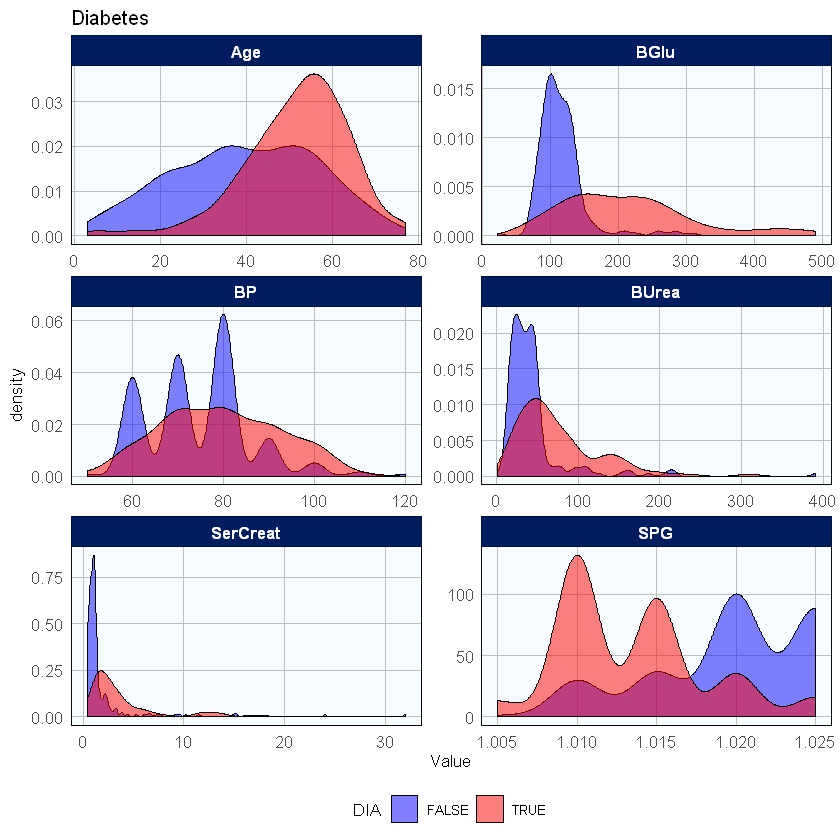

In [22]:
df %>% gather(c(Age,BP,SPG, BUrea:BGlu),
             key="Parameter",
             value="Value")%>%
  ggplot(aes(x=Value,fill=DIA))+
  geom_density(alpha=0.5)+
  ggtitle("Diabetes")+
  facet_wrap(~Parameter,ncol=2,scales="free")+
  scale_fill_manual(values = c("blue","red"))+
  my_theme()

## Phân tích Cluster

Chúng ta sẽ sử dụng package clusMixType cho phân tích cụm hỗn hợp, các bạn có thể cài đặt nó như sau:

In [ ]:
!install.packages("clustMixType")

Thông tin về package tại: 
https://cran.r-project.org/web/packages/clustMixType/index.html

Theo đó, tác giả áp dụng algorithm "k-prototypes partitioning clustering" của Zhexue Huang (1998) : 
https://link.springer.com/article/10.1023%2FA%3A1009769707641

Algorithm này cho phép chia không gian dữ liệu có chứa cả biến định tính và định lượng thành K cụm.

Trước khi thực hiện phân tích Clustering, Nhi chuẩn hóa toàn bộ 6 biến định lượng :
Chú ý: package clustMixType không nhận ra tibble của tidyverse, do đó bạn chuyển df thành dataframe của R trước:

In [41]:
scaled_df = df %>%as.data.frame()

scaled_df[,c(4,5,10,13:15)] <- scale(df[,c(4,5,10,13:15)])

head(scaled_df)

CKD,HTA,DIA,Age,BP,Bact,PCC,Anemia,PedEdema,SPG,Albumin,Sugar,BUrea,SerCreat,BGlu
TRUE,TRUE,TRUE,-0.33620155,0.3142428,notpresent,notpresent,no,no,0.3887572,1,0,-0.381912780,-0.3721040,-0.3335830
TRUE,FALSE,TRUE,0.63876179,0.3142428,notpresent,notpresent,yes,no,-1.3606503,2,3,-0.028251043,-0.2089071,3.5514882
TRUE,TRUE,FALSE,-0.33620155,-0.5085020,notpresent,present,yes,yes,-2.2353540,4,0,0.034159852,0.3350825,-0.3850409
TRUE,FALSE,FALSE,-0.09246072,0.3142428,notpresent,notpresent,no,no,-1.3606503,2,0,-0.589949095,-0.3177050,-0.5265501
TRUE,TRUE,TRUE,0.51689137,1.1369876,notpresent,notpresent,no,yes,-0.4859465,3,0,-0.610752727,-0.3993034,-0.9382132
TRUE,FALSE,FALSE,1.00437304,-0.5085020,notpresent,notpresent,no,no,-1.3606503,0,0,-0.007447411,5.8293770,-0.6037369


In [36]:
library(clustMixType)

Chúng ta chỉ làm phân tích Cluster trên 12 biến thông tin lâm sàng, nhưng không dùng đến 3 biến chẩn đoán (HTA, CKD và DIA).

In [42]:
X_mat = scaled_df %>% select(-c(1:3))

head(X_mat)

Age,BP,Bact,PCC,Anemia,PedEdema,SPG,Albumin,Sugar,BUrea,SerCreat,BGlu
-0.33620155,0.3142428,notpresent,notpresent,no,no,0.3887572,1,0,-0.381912780,-0.3721040,-0.3335830
0.63876179,0.3142428,notpresent,notpresent,yes,no,-1.3606503,2,3,-0.028251043,-0.2089071,3.5514882
-0.33620155,-0.5085020,notpresent,present,yes,yes,-2.2353540,4,0,0.034159852,0.3350825,-0.3850409
-0.09246072,0.3142428,notpresent,notpresent,no,no,-1.3606503,2,0,-0.589949095,-0.3177050,-0.5265501
0.51689137,1.1369876,notpresent,notpresent,no,yes,-0.4859465,3,0,-0.610752727,-0.3993034,-0.9382132
1.00437304,-0.5085020,notpresent,notpresent,no,no,-1.3606503,0,0,-0.007447411,5.8293770,-0.6037369


In [84]:
dim(X_mat)

[1] 288  12

Như ta biết, số cluster là một tham số quan trọng trong phân tích Cluster, nhưng nó cũng là 1 lựa chọn chủ quan. Qua thăm dò nhiều giá trị của số cluster từ 2-10, Nhi quyết định chọn giá trị k = 3

In [44]:
Es <- numeric(10)

for(i in 1:10){
  kpres <- kproto(X_mat, 
                  k = i, nstart = 5, 
                  lambda = lambdaest(X_mat),
                  verbose = FALSE)
  Es[i] <- kpres$tot.withinss}

Numeric variances:
     Age       BP      SPG    BUrea SerCreat     BGlu 
       1        1        1        1        1        1 
Average numeric variance: 1 

Heuristic for categorical variables: (method = 1) 
     Bact       PCC    Anemia  PedEdema   Albumin     Sugar 
0.1171875 0.2239342 0.2082369 0.2731240 0.6178144 0.3156346 
Average categorical variation: 0.2926553 

Estimated lambda: 3.416989 

Numeric variances:
     Age       BP      SPG    BUrea SerCreat     BGlu 
       1        1        1        1        1        1 
Average numeric variance: 1 

Heuristic for categorical variables: (method = 1) 
     Bact       PCC    Anemia  PedEdema   Albumin     Sugar 
0.1171875 0.2239342 0.2082369 0.2731240 0.6178144 0.3156346 
Average categorical variation: 0.2926553 

Estimated lambda: 3.416989 

Numeric variances:
     Age       BP      SPG    BUrea SerCreat     BGlu 
       1        1        1        1        1        1 
Average numeric variance: 1 

Heuristic for categorical variabl

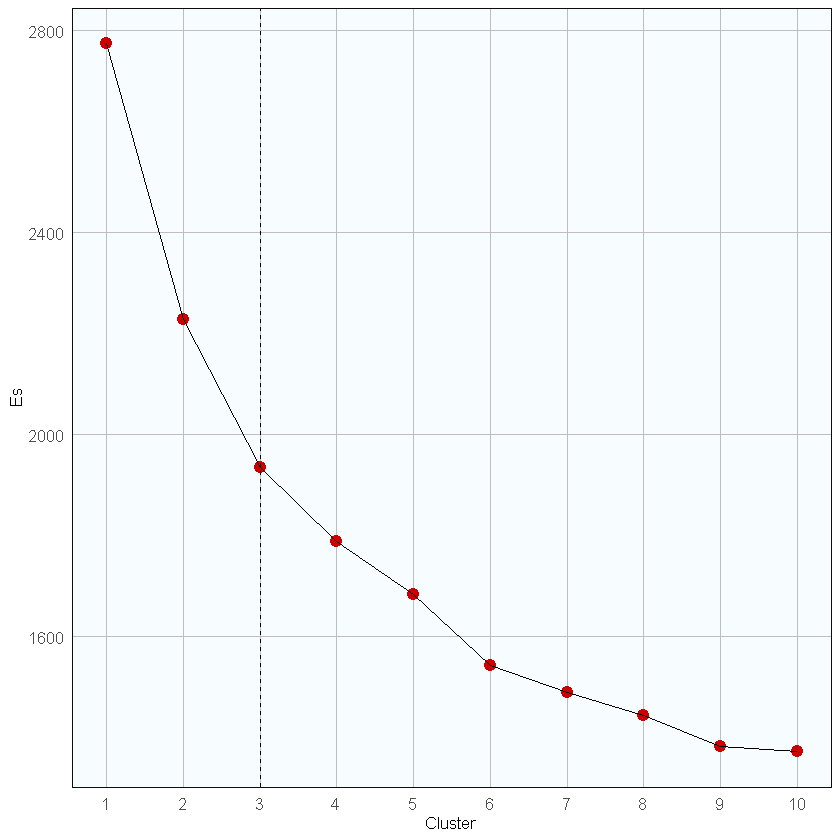

In [49]:
tibble(Cluster = c(1:10), Es = Es) %>% 
  ggplot(aes(x = Cluster, y = Es)) + 
  geom_point(size = 3, 
             col ="red3") +
  geom_path() + 
  geom_vline(xintercept = 3, 
             linetype = 2)+
  scale_x_continuous(breaks = c(1:10))

In [54]:
k_opt <- ptbiserial_kproto(data = X_mat, 
                           lambda = lambdaest(X_mat),
                           k = 2:10, 
                           nstart = 5, 
                           verbose = FALSE)

k_opt

Numeric variances:
     Age       BP      SPG    BUrea SerCreat     BGlu 
       1        1        1        1        1        1 
Average numeric variance: 1 

Heuristic for categorical variables: (method = 1) 
     Bact       PCC    Anemia  PedEdema   Albumin     Sugar 
0.1171875 0.2239342 0.2082369 0.2731240 0.6178144 0.3156346 
Average categorical variation: 0.2926553 

Estimated lambda: 3.416989 



$k_opt
[1] 4

$indices
        2         3         4         5         6         7         8         9 
0.4209480 0.4902762 0.4980917 0.3674142 0.3407872 0.3401235 0.2779504 0.2723341 
       10 
0.2827210

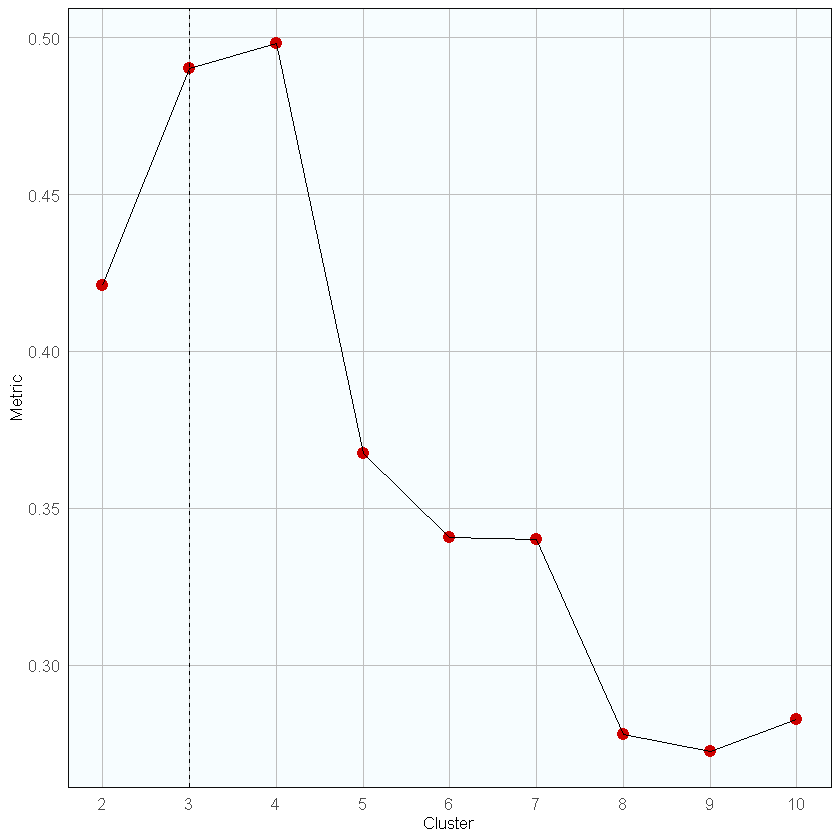

In [55]:
tibble(Cluster = c(2:10), 
       Metric = as.vector(k_opt$indices)) %>% 
  ggplot(aes(x = Cluster, 
             y = Metric)) + 
  geom_point(size = 3, 
             col ="red3") +
  geom_path() + 
  geom_vline(xintercept = 3, 
             linetype = 2)+
  scale_x_continuous(breaks = c(2:10))

Bây giờ, ta dùng hàm kproto để thực hiện phân tích Clustering trên dữ liệu đầu vào là X_mat, một matrix (288 x 12)

In [57]:
kpres_3 = kproto(x = X_mat,
                 k = 3,
                 lambda = lambdaest(X_mat))

Numeric variances:
     Age       BP      SPG    BUrea SerCreat     BGlu 
       1        1        1        1        1        1 
Average numeric variance: 1 

Heuristic for categorical variables: (method = 1) 
     Bact       PCC    Anemia  PedEdema   Albumin     Sugar 
0.1171875 0.2239342 0.2082369 0.2731240 0.6178144 0.3156346 
Average categorical variation: 0.2926553 

Estimated lambda: 3.416989 

# NAs in variables:
     Age       BP     Bact      PCC   Anemia PedEdema      SPG  Albumin 
       0        0        0        0        0        0        0        0 
   Sugar    BUrea SerCreat     BGlu 
       0        0        0        0 
0 observation(s) with NAs.



Khi gọi trực tiếp object kết quả, hay qua hàm summary, ta sẽ có một mô tả tóm tắt về đặc tính của từng cluster. Thuật ngữ gọi kết quả này là các "prototypes" hoặc "profiles"

In [58]:
kpres_3

Numeric predictors: 6 
Categorical predictors: 6 
Lambda: 3.416989 

Number of Clusters: 3 
Cluster sizes: 151 87 50 
Within cluster error: 404.0632 757.1814 880.0246 

Cluster prototypes:
         Age          BP       Bact        PCC Anemia PedEdema        SPG
1 -0.4859165 -0.40497780 notpresent notpresent     no       no  0.6899797
2  0.6170492  0.66414575 notpresent notpresent     no       no -0.6367575
3  0.3938022  0.06741936 notpresent notpresent     no       no -0.9757806
  Albumin Sugar       BUrea    SerCreat       BGlu
1       0     0 -0.45527658 -0.41659583 -0.4816522
2       0     0 -0.06373678 -0.07165916  0.1632519
3       3     0  1.48583726  1.38280634  1.1705313

In [59]:
summary(kpres_3)

Age 
       Min.    1st Qu.     Median       Mean   3rd Qu.     Max.
1 -2.468934 -1.2502297 -0.5190072 -0.4859165 0.2731505 1.735596
2 -2.042387  0.2122153  0.6387618  0.6170492 1.0348406 2.040272
3 -1.189294 -0.1229283  0.4559562  0.3938022 0.9282040 1.552790

-----------------------------------------------------------------
BP 
       Min.   1st Qu.     Median        Mean   3rd Qu.     Max.
1 -1.331247 -1.331247 -0.5085020 -0.40497780 0.3142428 1.136988
2 -2.153992 -0.508502  0.3142428  0.66414575 1.1369876 3.605222
3 -2.153992 -0.508502  0.3142428  0.06741936 0.3142428 2.782477

-----------------------------------------------------------------
Bact 
       
cluster notpresent present
      1      0.993   0.007
      2      0.908   0.092
      3      0.820   0.180

-----------------------------------------------------------------
PCC 
       
cluster notpresent present
      1      0.980   0.020
      2      0.816   0.184
      3      0.640   0.360

----------------------------------

## Khảo sát các prototypes

Để mô tả trực quan về 3 prototypes này, chúng ta sẽ kết hợp kết quả phân cụm (nhãn các cluster) vào dữ liệu gốc (df) :

In [62]:
valid_df = df %>% mutate(Cluster = as.factor( kpres_3$cluster))

Đầu tiên, ta sẽ xem phân bố của 6 biến định lượng khác nhau như thế nào giữa 3 clusters: 

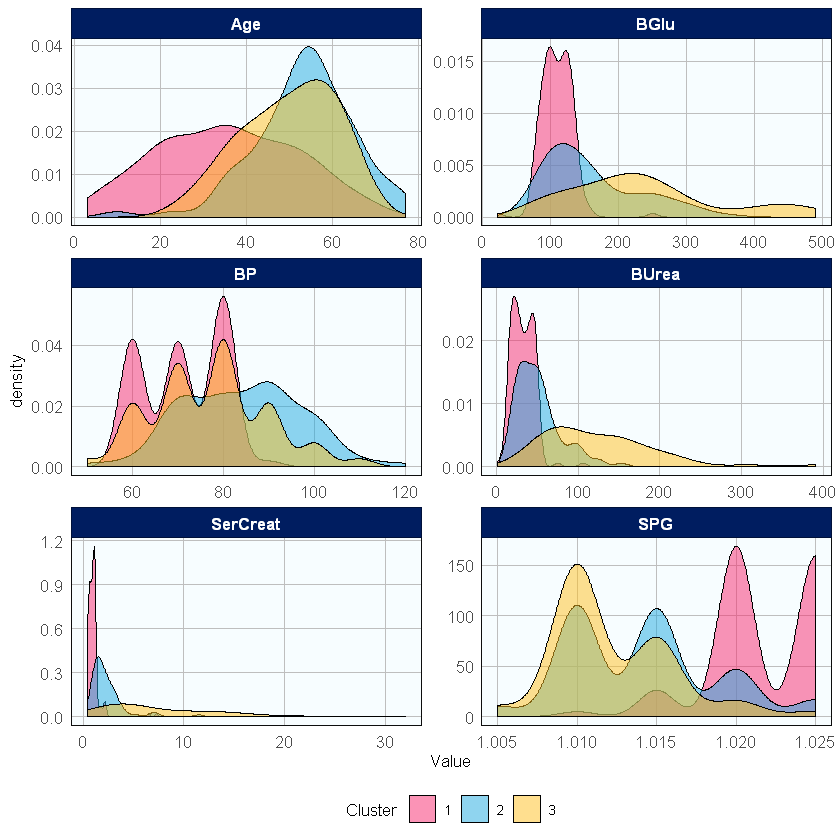

In [64]:
valid_df %>%gather(Age,BP,SPG,BGlu,BUrea,SerCreat,
                   key = "Para",value="Value")%>%
  ggplot(aes(x=Value, fill = Cluster))+
  geom_density(alpha=0.5,col="black")+
  facet_wrap(~Para,ncol=2,scales = "free")+
  scale_fill_manual(values=clust_colmap )

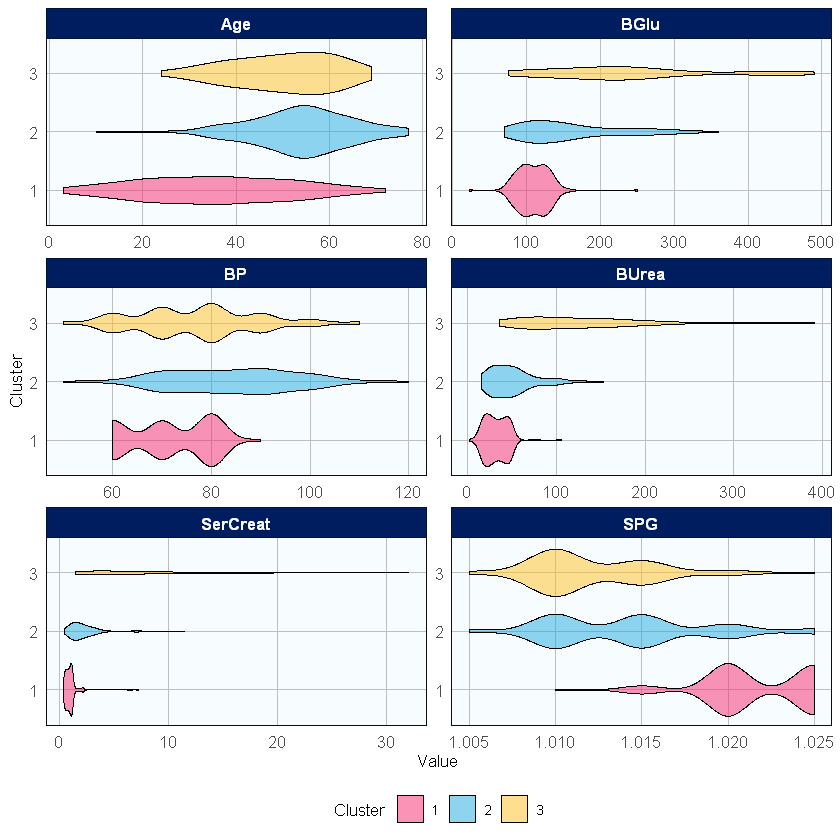

In [66]:
valid_df %>%gather(Age,BP,SPG,BGlu,BUrea,SerCreat, 
                   key = "Para",value="Value")%>%
  ggplot(aes(x = Cluster, y=Value, fill = Cluster))+
  geom_violin(alpha=0.5,col="black")+
  facet_wrap(~Para,ncol=2,scales = "free")+
  coord_flip()+
  scale_fill_manual(values=clust_colmap )

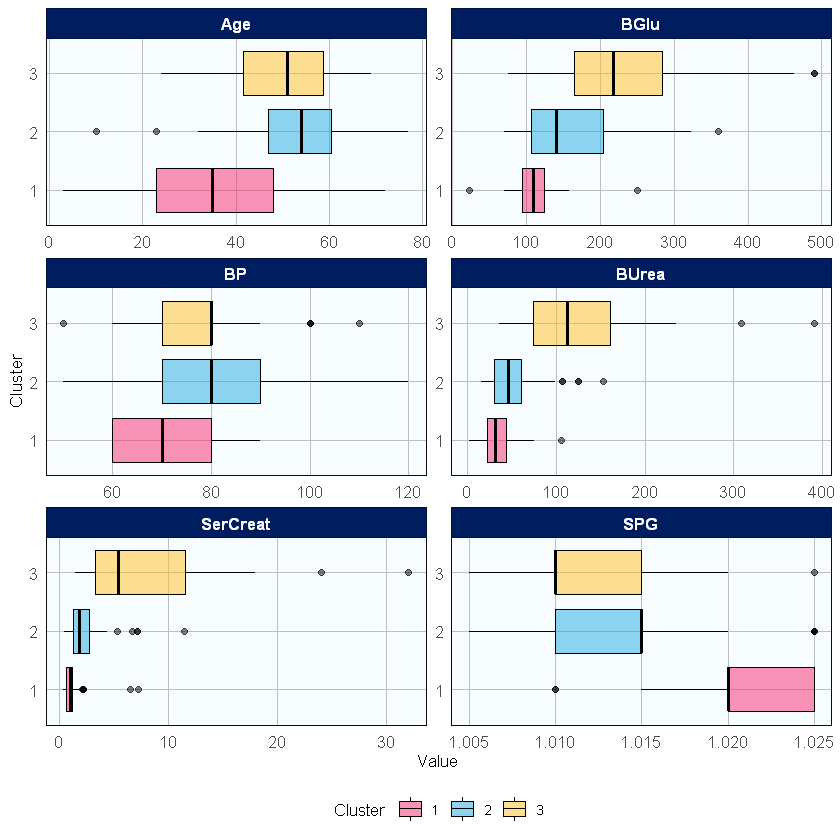

In [67]:
valid_df %>%gather(Age,BP,SPG,BGlu,BUrea,SerCreat, 
                   key = "Para",value="Value")%>%
  ggplot(aes(x = Cluster, y=Value, fill = Cluster))+
  geom_boxplot(alpha=0.5,col="black")+
  facet_wrap(~Para,ncol=2,scales = "free")+
  coord_flip()+
  scale_fill_manual(values=clust_colmap )

Theo kết quả này, ta có thể mô tả các prototypes như sau:

Cluster 1 có đặc tính: trẻ tuổi, huyết áp thấp, giá trị BGlu, Serum creatinine và Urea thấp; 


Cluster 3 gồm các bệnh nhân cao tuổi, Blood glucose cao, Urea và Creatitine cao ...

Tương tự, ta cũng có thể so sánh cấu trúc phân bố của những biến định tính giữa 3 cluster bằng biểu đồ cột chồng như sau:

Warning message:
"attributes are not identical across measure variables;
they will be dropped"

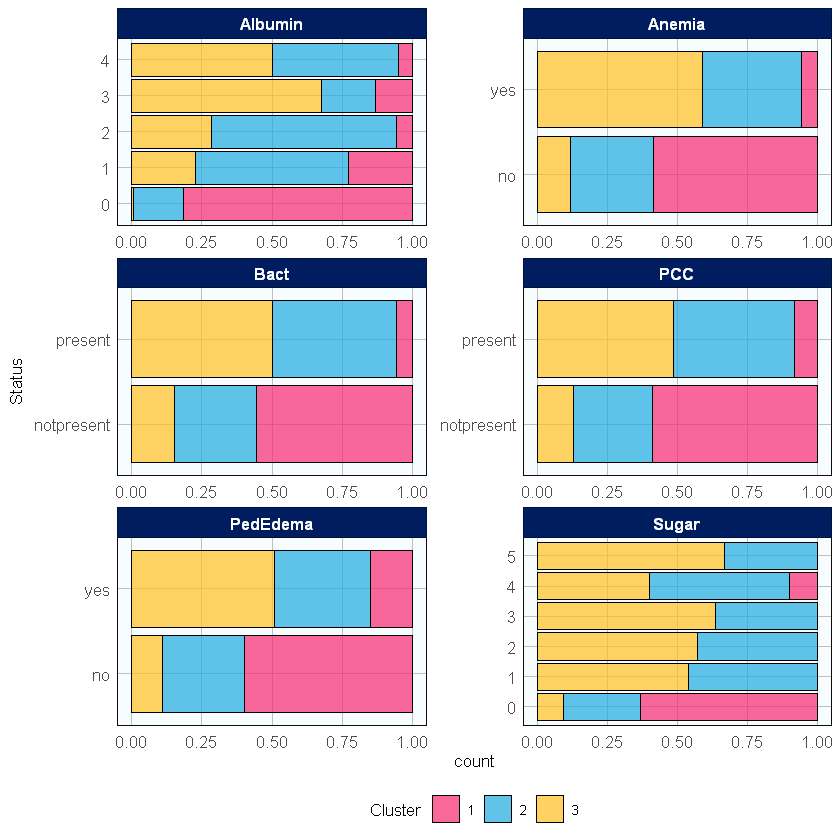

In [68]:
valid_df %>% gather(Bact,PCC,Anemia,PedEdema,Albumin,Sugar,
                    key="Factor",value="Status")%>%
  ggplot(aes(x=Status,fill=Cluster))+
  geom_bar(stat = "count",position="fill",show.legend = T,alpha=0.7,col="black")+
  scale_fill_manual(values=clust_colmap)+
  coord_flip()+
  facet_wrap(~Factor,ncol=2,scales = "free")

Warning message:
"attributes are not identical across measure variables;
they will be dropped"

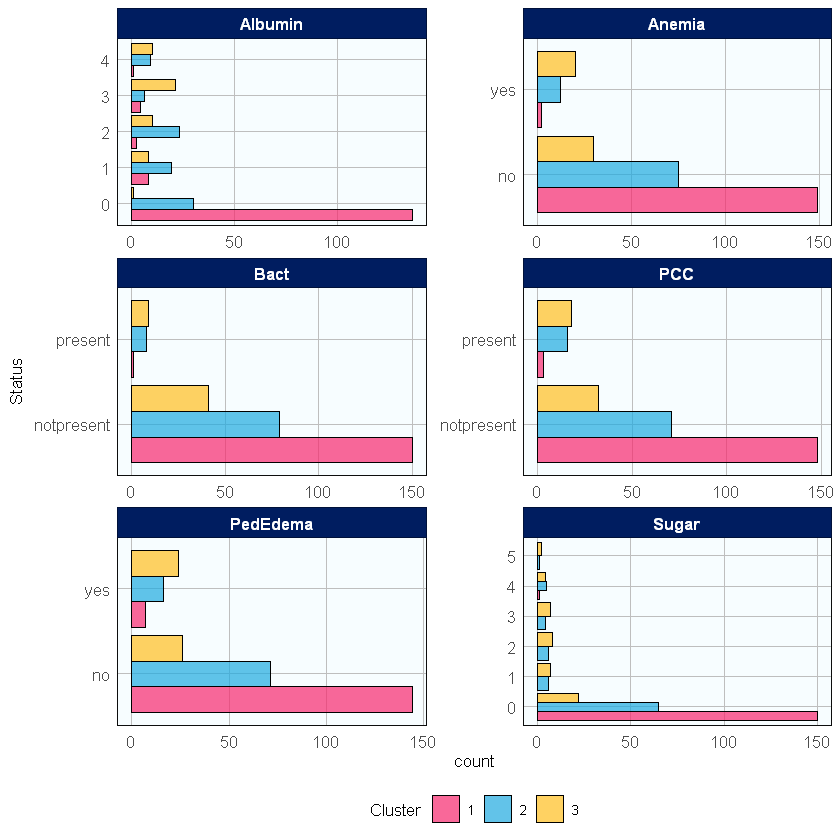

In [70]:
valid_df %>% gather(Bact,PCC,Anemia,PedEdema,Albumin,Sugar,
                    key="Factor",value="Status")%>%
  ggplot(aes(x=Status,fill=Cluster))+
  geom_bar(stat = "count",position="dodge",show.legend = T,alpha=0.7,col="black")+
  scale_fill_manual(values=clust_colmap)+
  coord_flip()+
  facet_wrap(~Factor,ncol=2,scales = "free")

Warning message:
"attributes are not identical across measure variables;
they will be dropped"

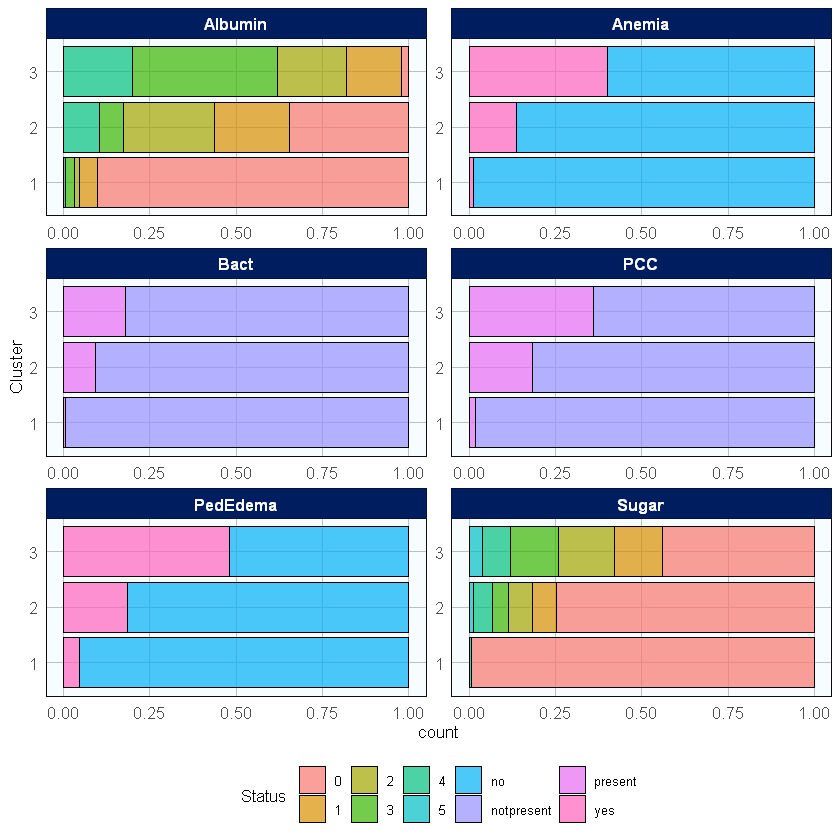

In [71]:
valid_df %>% gather(Bact,PCC,Anemia,PedEdema,Albumin,Sugar,
                    key="Factor",value="Status")%>%
  ggplot(aes(x=Cluster,fill= Status))+
  geom_bar(stat = "count",position="fill",show.legend = T,alpha=0.7,col="black")+
  coord_flip()+
  facet_wrap(~Factor,ncol=2,scales = "free")

Chúng ta cũng có thể sử dụng biểu đồ KDE 2 chiều để khảo sát hình ảnh phân bố của 3 cluster trên một mặt phẳng 2 chiều tạo ra bởi 1 cặp biến định lượng bất kì.

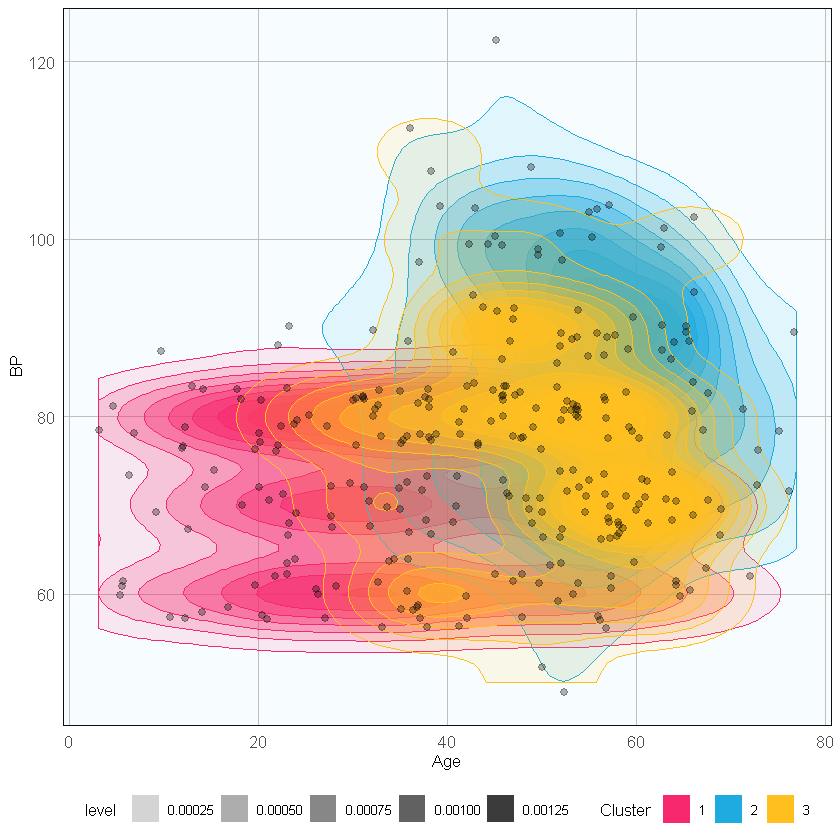

In [72]:
valid_df %>% ggplot(aes(x=Age,y=BP))+
  stat_density2d(geom="polygon",
                 aes(fill=Cluster,
                     col = Cluster,
                     alpha = ..level..))+
  geom_jitter(color="black",size=2, alpha = 0.3)+
  scale_fill_manual(values=clust_colmap)+
  scale_color_manual(values=clust_colmap)

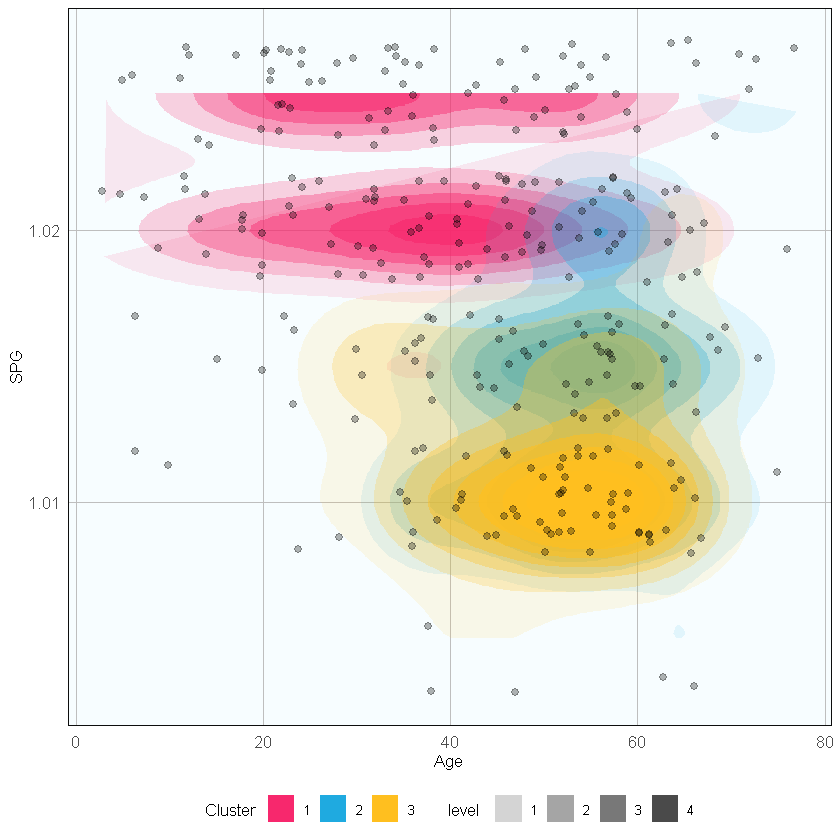

In [73]:
valid_df %>% ggplot(aes(x=Age,y=SPG))+
  stat_density2d(geom="polygon",
                 aes(fill=Cluster,alpha = ..level..))+
  geom_jitter(color="black",size=2, alpha = 0.3)+B
  scale_fill_manual(values=clust_colmap)

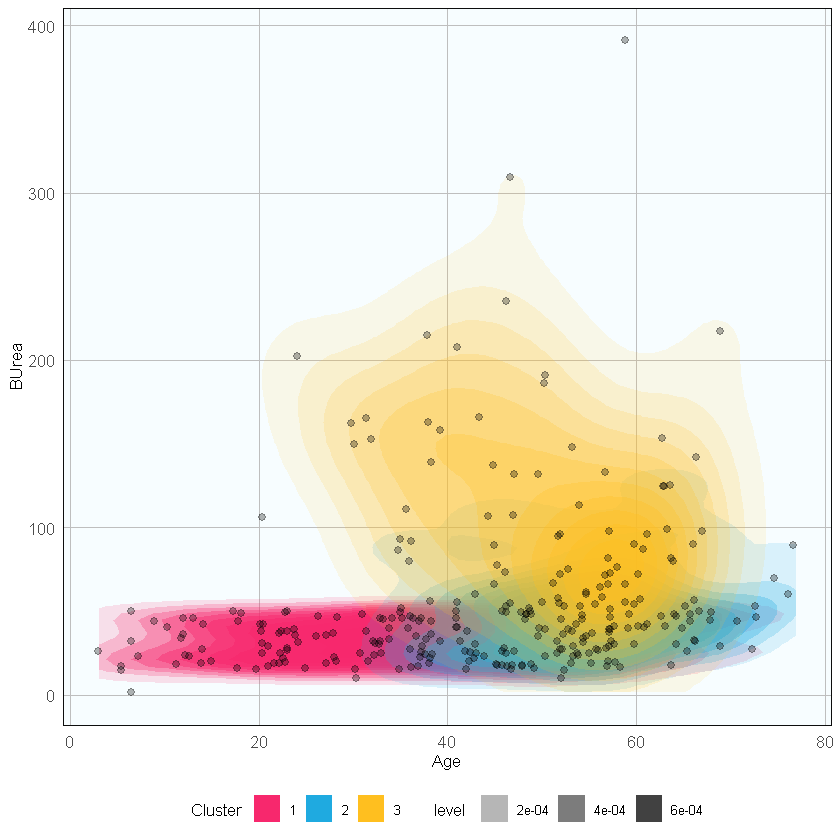

In [80]:
valid_df %>% ggplot(aes(x=Age,y=BUrea))+
  stat_density2d(geom="polygon",
                 aes(fill=Cluster,alpha = ..level..))+
  geom_jitter(color="black",size=2, alpha = 0.3)+
  scale_fill_manual(values=clust_colmap)

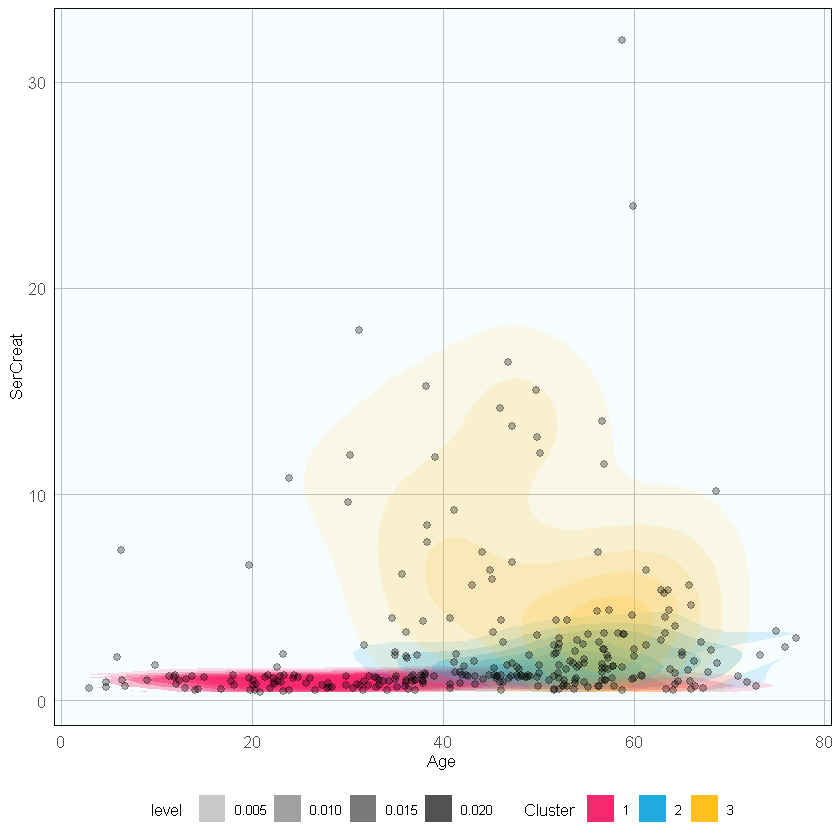

In [82]:
valid_df %>% ggplot(aes(x=Age,y=SerCreat))+
  stat_density2d(geom="polygon",
                 aes(fill=Cluster,alpha = ..level..))+
  geom_jitter(color="black",size=2, alpha = 0.3)+
  scale_fill_manual(values=clust_colmap)

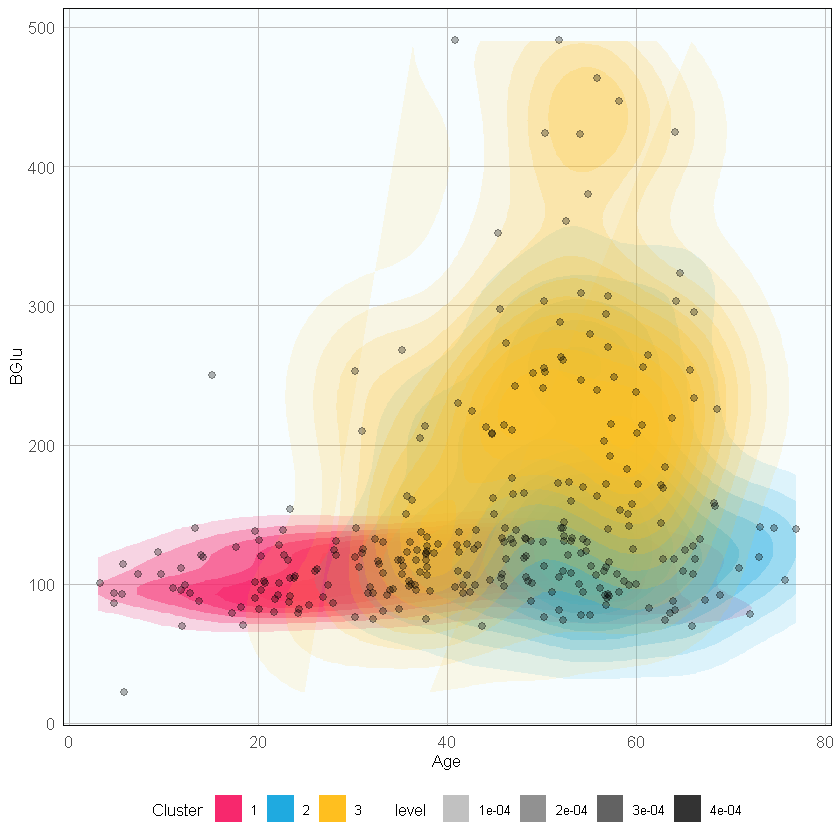

In [83]:
valid_df %>% ggplot(aes(x=Age,y=BGlu))+
  stat_density2d(geom="polygon",
                 aes(fill=Cluster,alpha = ..level..))+
  geom_jitter(color="black",size=2, alpha = 0.3)+
  scale_fill_manual(values=clust_colmap)

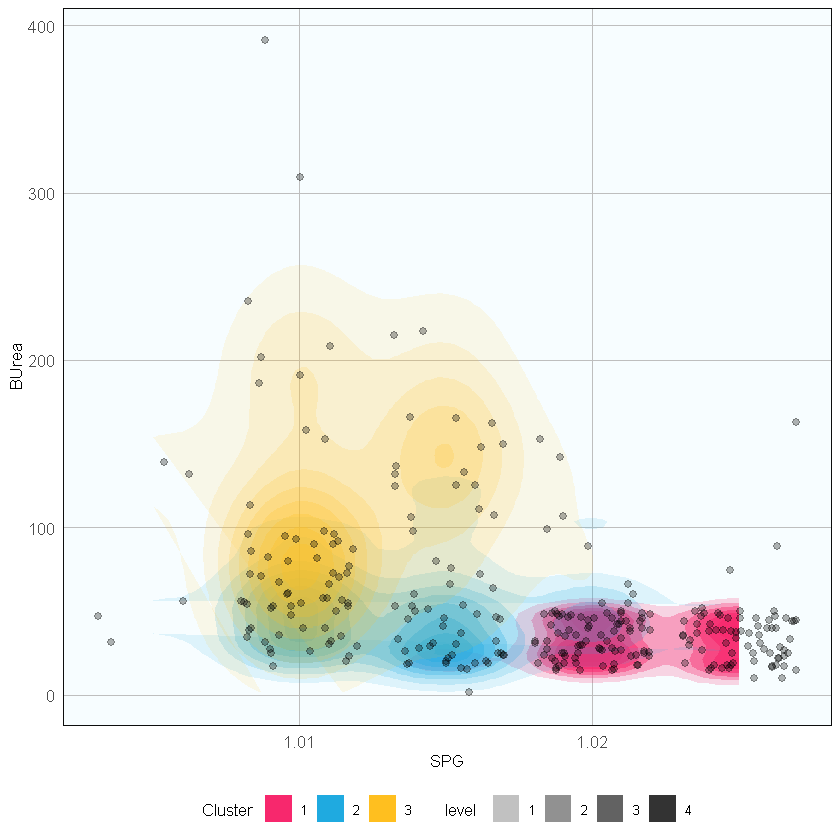

In [74]:
valid_df %>% ggplot(aes(x=SPG,y= BUrea))+
  stat_density2d(geom="polygon",
                 aes(fill=Cluster,alpha = ..level..))+
  geom_jitter(color="black",size=2, alpha = 0.3)+
  scale_fill_manual(values=clust_colmap)

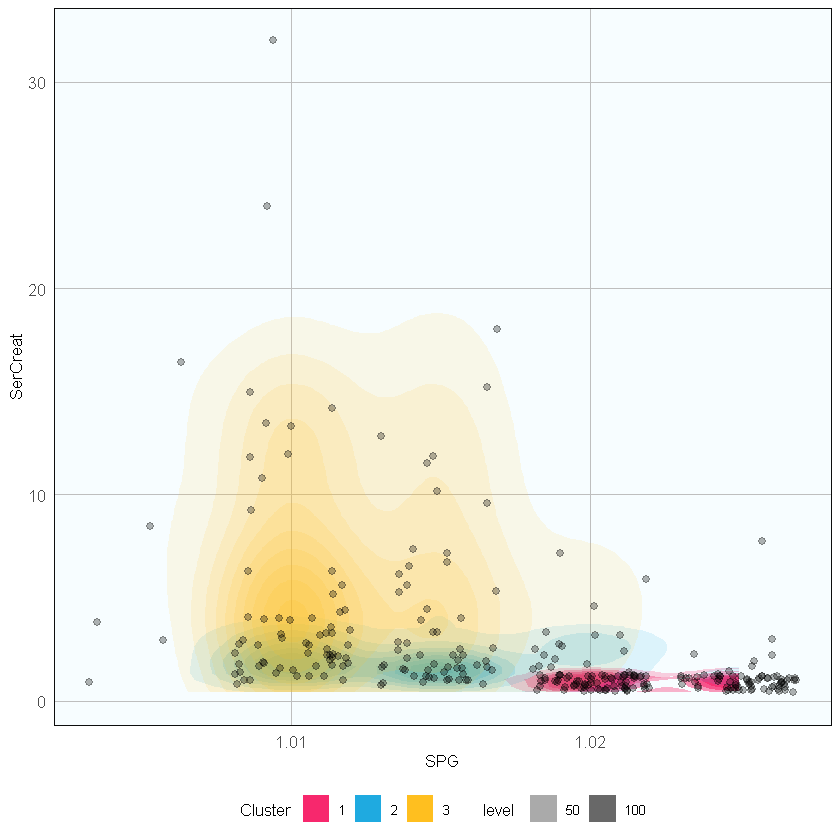

In [75]:
valid_df %>% ggplot(aes(x=SPG,y= SerCreat))+
  stat_density2d(geom="polygon",
                 aes(fill=Cluster,alpha = ..level..))+
  geom_jitter(color="black",size=2, alpha = 0.3)+
  scale_fill_manual(values=clust_colmap)

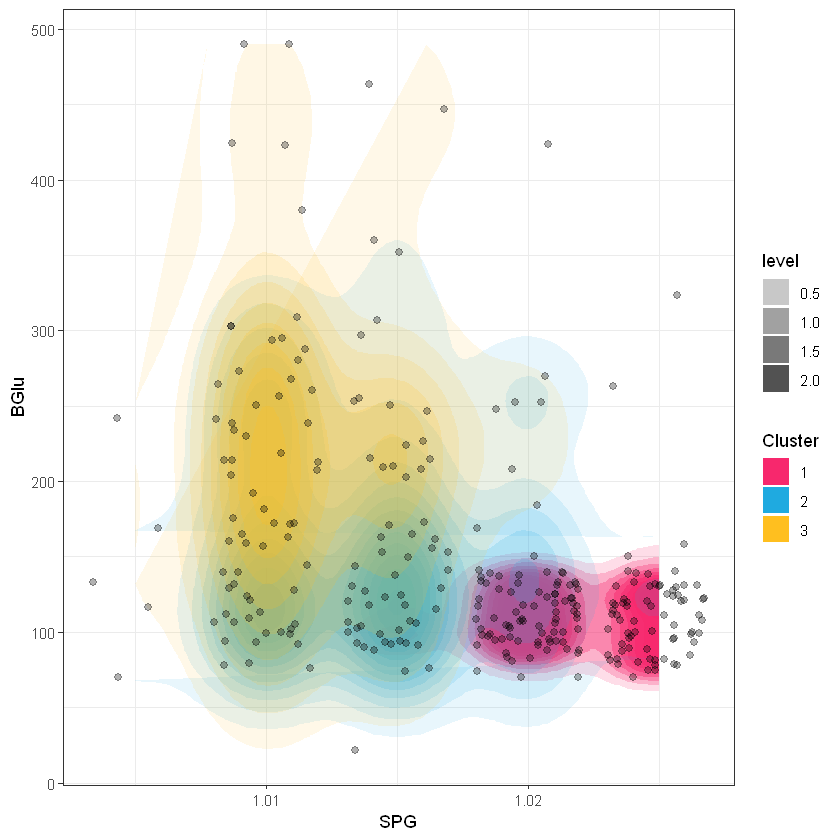

In [76]:
valid_df %>% ggplot(aes(x=SPG,y=BGlu))+
  stat_density2d(geom="polygon",
                 aes(fill=Cluster,alpha = ..level..))+
  geom_jitter(color="black",size=2, alpha = 0.3)+
  theme_bw()+
  scale_fill_manual(values=clust_colmap)

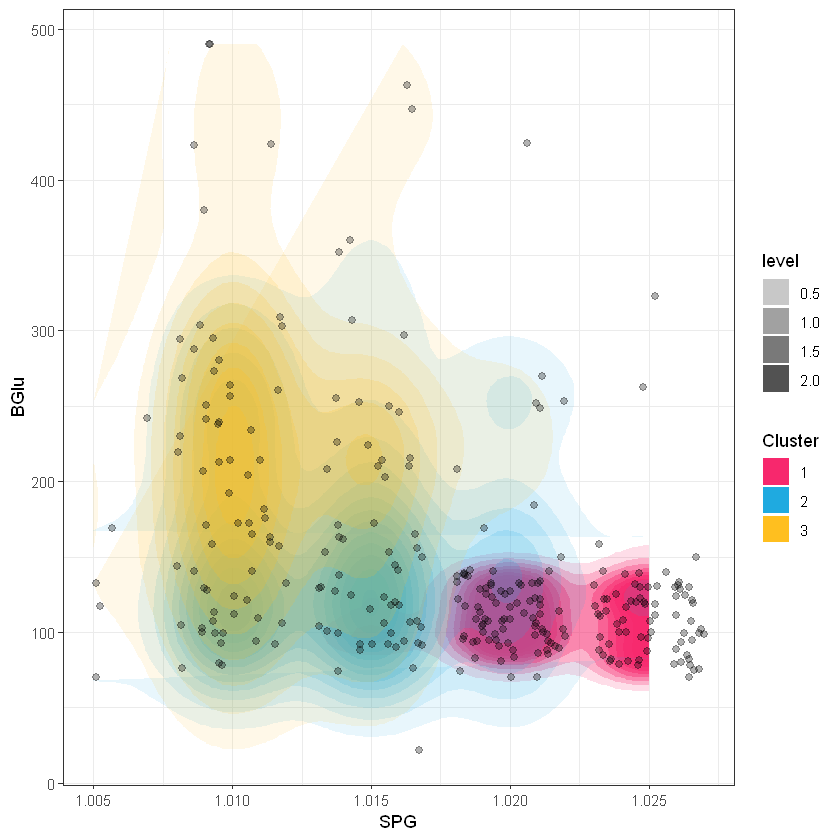

In [79]:
valid_df %>% ggplot(aes(x=SPG, y= BGlu))+
  stat_density2d(geom="polygon",
                 aes(fill=Cluster,alpha = ..level..))+
  geom_jitter(color="black",size=2, alpha = 0.3)+
  theme_bw()+
  scale_fill_manual(values=clust_colmap)

## Liên hệ giữa các Cluster và Bệnh lý 

Cuối cùng, các bạn cùng Nhi install package "circlize" để vẽ một Chord diagram, nhằm trả lời câu hỏi về mối tương quan giữa 3 cluster được tạo thành và 3 bệnh lý : Cao huyết áp, bệnh thận mạn và Tiểu đường: 

In [60]:
!install.packages('circlize')

also installing the dependencies 'GlobalOptions', 'shape'



package 'GlobalOptions' successfully unpacked and MD5 sums checked
package 'shape' successfully unpacked and MD5 sums checked
package 'circlize' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\bacsi\AppData\Local\Temp\Rtmp0iJ3yv\downloaded_packages


ERROR: Error in !install.packages("circlize"): type de l'argument incorrect


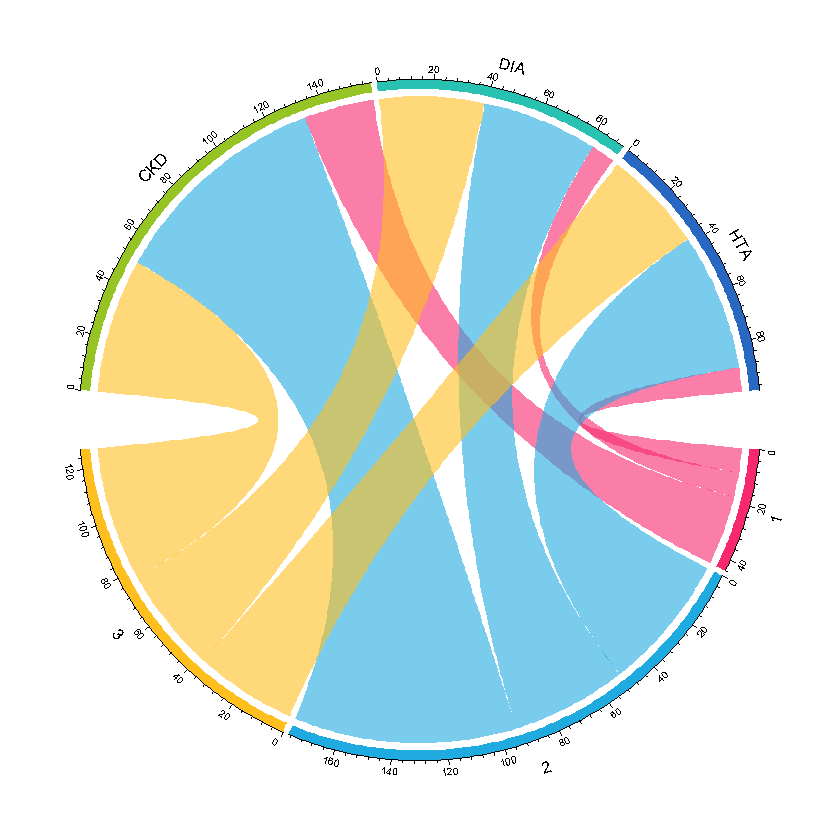

In [63]:
library(circlize)

xtb_y = valid_df %>% 
    mutate(Id=rownames(valid_df))%>%
    gather(HTA,CKD,DIA,
           key="Pathology",
           value="Diagnosis")%>%
  group_by(Cluster,Diagnosis,Pathology)%>%
  summarise(frequency = n())%>%
  filter(Diagnosis=="TRUE")

xtb_y = xtb_y%>%.[,c(1,3,4)]

grid.col = c(`1` ="#f7286d",
             `2` ="#1faae0",
             `3` ="#ffbf1f",
             `HTA`= "#2968c2",
             `CKD`= "#97c425",
             `DIA`= "#29c2b2"
            )

chordDiagram(as.data.frame(xtb_y), 
             transparency = 0.4,
             grid.col = grid.col, 
             column.col ="black")

Biểu đồ cho thấy cả 3 cluster đều có liên hệ với mỗi một trong 3 bệnh lý được khảo sát.

## Bàn luận

Chúng ta vừa thực hiện một phân tích cụm (Cluster analysis) đặc biệt, vì dữ liệu đầu vào là một hỗn hợp gồm cả biến định tính (thậm chí nhiều level) và biến định lượng. Theo quy ước cổ điển, clustering chỉ áp dụng cho dữ liệu định lượng. Với algorithm k-prototypes, các bạn đã có trong tay một công cụ phổ quát có thể áp dụng cho bất cứ dữ liệu nào, đặc biệt trong các hoàn cảnh mà bạn chưa có một mục tiêu hay giả thuyết nào rõ ràng. 

Tuy đây chỉ là một bài thực hành mang tính minh họa, nhưng những gì mà bạn thấy trong bài ***Không*** phải là vô nghĩa. Có một thông điệp thú vị và quan trọng mà Nhi đọc được từ thí nghiệm này: Trong nghiên cứu y học, chúng ta thường quá chủ quan và hạn hẹp khi đặt ra giả thuyết ban đầu, từ đó dẫn tới việc áp dụng thiết kế thí nghiệm kiểu Bệnh/Chứng (Case control), trong đó mục tiêu là tìm sự tương phản giữa 2 phân nhóm: nhóm bệnh gồm toàn bệnh nhân mắc một bệnh lý duy nhất (thí dụ Suy thận mạn), và nhóm chứng gồm toàn những người hoàn toàn bình thường. Hậu quả của góc nhìn hạn hẹp này đó là những kết quả tìm được KHÔNG thể áp dụng được trên thực tế: Vì trong đời thực chúng ta đối diện với bệnh nhân với nhiều bệnh lý chồng lắp lên nhau (mặt khác, không có người hoàn toàn khỏe mạnh nào lại đến bệnh viện khám bệnh cả), một kết quả bất thường có thể do nhiều nguyên nhân tương tác, kết hợp với nhau chứ không chuyên biệt cho một bệnh duy nhất... 

Để làm những nghiên cứu gần với đời thực, phải chăng ta nên sử dụng nhiều hơn phân tích đa biến (multivariate analysis) và các phương pháp Unsupervised learning như Clustering thay vì đi theo định hướng chủ quan của bản thân và giới hạn trong các phân tích đơn biến ?

Tạm biệt các bạn và hẹn gặp lại